In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import
import pyreadr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from utility.lib import probe_to_gene
from utility.get_data import load_rdata


In [3]:
!pwd

/home/hugo/code/ER_status_prediction/notebook


We are going to train a machine learning model to classify Breast cancer ER (Estrogen receptors) positive and 
negative based on transcriptomic data 

This dataset was originally found [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=gse7390)


In [4]:
# dowload affymetrix dataset in data folder
! ../script/get_affy_data.sh

--2022-06-25 19:40:34--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE7nnn/GSE7390/suppl/GSE7390_transbig2006affy.RData.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 2607:f220:41e:250::13, 2607:f220:41f:250::230, 130.14.250.12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|2607:f220:41e:250::13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33953586 (32M) [application/x-gzip]
Saving to: ‘GSE7390_transbig2006affy.RData.gz’

GSE7390_transbig200 100%[===================>]  32.38M  1.81MB/s    in 16s     

2022-06-25 19:40:51 (1.96 MB/s) - ‘GSE7390_transbig2006affy.RData.gz’ saved [33953586/33953586]



In [5]:
# load .rDATA
df, annot, demo = load_rdata()

In [6]:
print(df.shape) # extract gene expression
print(annot.shape) # extract gene information/description
print(demo.shape) # extract clinical data including ER status

(198, 22283)
(22283, 10)
(198, 28)


In [7]:
demo.head()

,samplename,id,filename,hospital,age,size,Surgery_type,Histtype,Angioinv,Lymp_infil,...,e.dmfs,t.tdm,e.tdm,risksg,NPI,risknpi,AOL_os_10y,risk_AOL,veridex_risk,geno_accn
rownames,,,,,,,,,,,,,,,,,,,,,
VDXGUYU_4002,VDXGUYU_4002,4002,10-4002_GUYA.CEL.gz,GUY,57,3.0,0,1,1,2,...,1,723,1,Poor,4.60,Poor,62.7,Poor,Poor,GSM177885
VDXGUYU_4008,VDXGUYU_4008,4008,26-4008_GUYA.CEL.gz,GUY,57,3.0,0,2,1,3,...,0,6591,0,Poor,4.60,Poor,69.0,Poor,Poor,GSM177886
VDXGUYU_4011,VDXGUYU_4011,4011,6-4011_GUYA.CEL.gz,GUY,48,2.5,1,1,0,2,...,1,524,1,Poor,4.50,Poor,66.2,Poor,Poor,GSM177887
VDXGUYU_4014,VDXGUYU_4014,4014,9-4014_GUYA.CEL.gz,GUY,42,1.8,0,1,1,3,...,1,6255,0,Poor,4.36,Poor,84.9,Poor,Poor,GSM177888
VDXGUYU_4022,VDXGUYU_4022,4022,219-4022_GUYA.CEL.gz,GUY,46,3.0,0,1,1,2,...,1,3822,1,Poor,3.60,Poor,80.2,Poor,Poor,GSM177889


In [8]:
df.head()

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
VDXGUYU_4002,10.780787,8.674201,7.738589,9.285511,6.610484,8.505162,6.867181,7.168175,6.252700,5.262454,...,8.921485,9.313626,14.888195,14.369094,2.929942,5.680176,1.753631,2.223181,4.013873,1.603252
VDXGUYU_4008,11.335393,9.354759,7.763657,9.025809,4.809869,8.674612,5.097706,5.654260,9.892701,3.438981,...,8.696506,8.711194,15.011879,14.545059,2.667544,2.888221,1.767325,2.013092,5.355048,2.455589
VDXGUYU_4011,11.028074,9.053889,6.327600,9.234409,4.621973,8.406754,6.932156,6.263502,8.777121,4.738016,...,7.975107,9.370440,15.170855,14.838521,3.258987,3.464008,4.875803,0.581058,4.054644,2.021403
VDXGUYU_4014,11.847736,9.139895,7.032598,9.656416,5.589404,9.106449,7.751138,6.371654,11.993179,5.185123,...,9.130724,9.413045,15.126623,14.702279,3.865262,5.564328,3.361199,2.251075,4.760490,2.365204
VDXGUYU_4022,12.359239,9.196708,7.873428,9.174188,5.325173,10.030778,7.156790,4.057771,6.359531,6.061211,...,8.028944,8.596815,15.492080,14.936844,3.321554,5.957565,2.400875,4.915962,6.120431,2.774229


In [9]:
annot.head()

,probe,EntrezGene.ID,probe.name,Alignment.score,Length.of.probe,NCBI.gene.symbol,HUGO.gene.symbol,Cytoband,Alternative.symbols,Description
rownames,,,,,,,,,,
1007_s_at,1007_s_at,780,1007_s_at,16,16,DDR1,DDR1,6p21.3,CAK|CD167|DDR|EDDR1|MCK10|NEP|NTRK4|PTK3|PTK3A...,"discoidin domain receptor family, member 1"
1053_at,1053_at,5982,1053_at,13,16,RFC2,RFC2,7q11.23,A1|MGC3665|RFC40,"replication factor C (activator 1) 2, 40kDa"
117_at,117_at,3310,117_at,16,16,HSPA6,HSPA6,1q23,NaN,heat shock 70kDa protein 6 (HSP70B')
121_at,121_at,7849,121_at,14,16,PAX8,PAX8,2q12-q14,NaN,paired box gene 8
1255_g_at,1255_g_at,2978,1255_g_at,16,16,GUCA1A,GUCA1A,6p21.1,COD3|GCAP|GCAP1|GUCA|GUCA1,guanylate cyclase activator 1A (retina)


In [10]:
gene_list = annot["HUGO.gene.symbol"].tolist()
print(f"{len(gene_list)} total genes")

# housekeeping gene use for control
housekeeping_gene = [colname for colname in list(df.columns) if str(colname).startswith('AFFX')]
print(f"{len(housekeeping_gene)} housekeeping gene")

unknow_gene = [gene for gene in gene_list if str(gene) == 'nan']
print(f"{len(unknow_gene)} unknow_gene")

# remove thoses gene from df
df.drop(housekeeping_gene, inplace=True, axis=1)

22283 total genes
68 housekeeping gene
5419 unknow_gene


In [12]:
# saved dataframe
df_er = pd.concat([df, demo['er']], axis=1)
df_er.to_csv("../data/gene_expression_er.csv", index=False)
annot.to_csv("../data/annot.csv", index=False)
df_er

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,91580_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at,er
VDXGUYU_4002,10.780787,8.674201,7.738589,9.285511,6.610484,8.505162,6.867181,7.168175,6.252700,5.262454,...,4.055948,4.659214,7.834107,8.957006,7.390298,8.603322,8.534263,8.404081,6.642913,0
VDXGUYU_4008,11.335393,9.354759,7.763657,9.025809,4.809869,8.674612,5.097706,5.654260,9.892701,3.438981,...,4.721726,7.414131,7.492440,9.554207,7.221574,7.283642,8.195115,7.160975,7.526977,1
VDXGUYU_4011,11.028074,9.053889,6.327600,9.234409,4.621973,8.406754,6.932156,6.263502,8.777121,4.738016,...,3.540740,7.450703,7.524904,8.971317,8.330001,8.351362,8.103304,7.279501,7.165591,0
VDXGUYU_4014,11.847736,9.139895,7.032598,9.656416,5.589404,9.106449,7.751138,6.371654,11.993179,5.185123,...,2.910142,7.577435,7.405859,10.589735,8.189784,7.289380,8.506713,8.046931,6.439499,1
VDXGUYU_4022,12.359239,9.196708,7.873428,9.174188,5.325173,10.030778,7.156790,4.057771,6.359531,6.061211,...,6.406668,8.519931,7.633125,9.052312,8.102586,9.102043,9.544095,7.166111,8.627155,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VDXRHU_5228,10.785023,10.012078,6.855161,8.987488,5.833270,8.030344,5.473191,5.683147,10.456655,4.828817,...,2.118412,7.678996,8.450637,10.404560,7.430358,8.957046,6.040766,8.380360,6.680919,0
VDXRHU_5232,11.390198,9.830344,7.150656,8.766830,3.977743,8.014831,5.364158,6.170392,9.249901,5.571832,...,3.751159,7.351305,8.156723,10.123040,7.022056,9.623054,9.230266,7.466369,8.067021,0
VDXRHU_5235,10.735085,8.894038,7.262618,9.064142,3.781916,9.533836,7.063272,5.451382,8.613225,4.774023,...,3.067258,7.155768,5.589756,9.320891,7.252039,7.722694,8.463029,8.144946,6.995964,1
VDXRHU_5236,10.653104,8.854766,6.636791,9.283177,3.724769,9.722750,7.616948,4.402618,12.423745,5.884242,...,5.915134,8.147412,8.167496,10.205495,8.233159,7.431613,8.483289,8.829224,7.524969,1


We have 22216 gene including ER cancer status for the 198 patients. Now, lets look at the distribution of patient 
without and ER cancer.

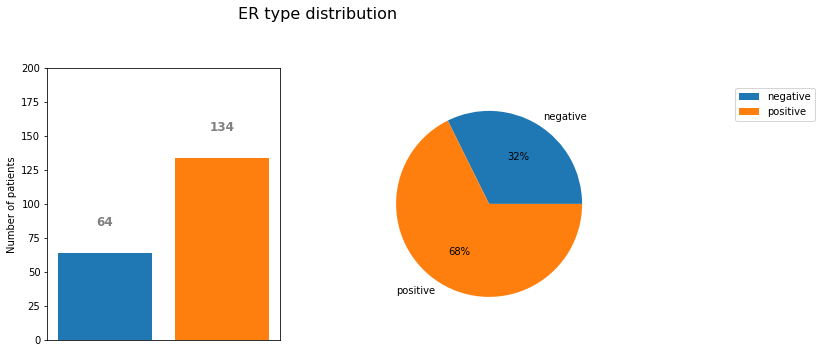

In [13]:
tumors_type = {'0': 'negative', '1': 'positive'}
labels, counts = np.unique(demo['er'], return_counts=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot frequency
ax[0].bar(labels[0], counts[0], label=tumors_type[str(labels[0])])
ax[0].bar(labels[1], counts[1], label=tumors_type[str(labels[1])])
ax[0].set_ylabel('Number of patients')
ax[0].axes.get_xaxis().set_ticks([])
ax[0].set_ylim([0, 200])

for i in ax[0].patches:
    height = i.get_height()
    ax[0].text((i.get_x() + i.get_width()/2.0), height + 20 , str(i.get_height()), ha='center',
            fontsize=12, fontweight='bold', color='grey')

#create pie chart
colors = sns.color_palette('pastel')[0:2]
ax[1].pie(counts, labels = tumors_type.values(), autopct='%.0f%%')
ax[1].legend(bbox_to_anchor=(1.9, 1), loc='upper right', borderaxespad=0)

fig.suptitle("ER type distribution", fontsize=16, y=1.05)
plt.subplots_adjust(wspace=0.4)
plt.show()

We have an unbalance dataset (about 1:2 ration) with more ER positive patients. Now, we going to see if we can
cluster this 2 groups using gene expression by clustering. We used PCA and T-SNE

In [14]:
# standardize the data for dimensionality reduction 
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
y = demo['er']

In [17]:
# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
Df_pca = pd.DataFrame(data = principalComponents, columns = ['PCA1', 'PCA2'])

# Tsne
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x)
Df_tsne = pd.DataFrame(data = tsne_results, columns = ['tsne-2d-one', 'tsne-2d-two'])

finalDf = pd.concat([Df_pca, Df_tsne], axis=1)
finalDf.index = df.index
finalDf['er'] = y.values
finalDf

/home/hugo/anaconda3/envs/er_cancer/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hugo/anaconda3/envs/er_cancer/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.003s...
[t-SNE] Computed neighbors for 198 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 47.255617
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.812492
[t-SNE] KL divergence after 300 iterations: 1.762275


,PCA1,PCA2,tsne-2d-one,tsne-2d-two,er
VDXGUYU_4002,16.020872,0.228754,-14.463731,-16.122089,0
VDXGUYU_4008,49.906214,29.697794,-3.551964,27.254276,1
VDXGUYU_4011,22.056739,-31.969577,-21.245045,-0.682324,0
VDXGUYU_4014,37.286681,31.482767,22.459864,-11.013136,1
VDXGUYU_4022,-27.171203,39.283257,27.539238,14.136993,1
...,...,...,...,...,...
VDXRHU_5228,91.083093,23.995551,-29.184666,-9.622756,0
VDXRHU_5232,76.238661,8.553069,-25.361887,-6.634259,0
VDXRHU_5235,-18.771190,19.483069,-0.060747,22.774960,1
VDXRHU_5236,10.347173,22.544427,28.657883,3.894384,1


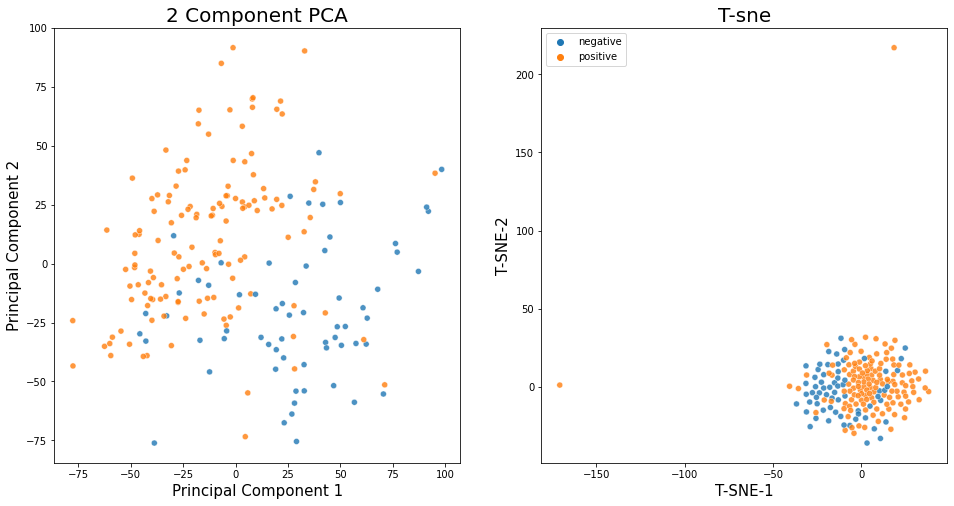

In [18]:
# lets plot PCA and T-SNE variable accoring to ER groups

plt.figure(figsize=(16,8))

tumors_type = {'0': 'negative', '1': 'positive'}

color_dict = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c'}
color_dict = {1: 'b', 2: 'g', 3: 'r'}

ax1 = plt.subplot(1, 2, 1)
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('2 Component PCA', fontsize = 20)

sns.scatterplot(
    x="PCA1", y="PCA2",
    hue="er",
    data=finalDf,
    #palette='Set2', 
    alpha=0.8,
    legend=None,
    ax=ax1)

ax2 = plt.subplot(1, 2, 2)
ax2.set_xlabel('T-SNE-1', fontsize = 15)
ax2.set_ylabel('T-SNE-2', fontsize = 15)
ax2.set_title('T-sne', fontsize = 20)

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="er",
    data=finalDf,
    #palette='Set2', 
    alpha=0.8,
    ax=ax2)


handles, labels  =  ax2.get_legend_handles_labels()
tumors_labels = [tumors_type[label] for label in labels]

ax2.legend(loc='upper right', bbox_to_anchor=(0.5, -0.5), ncol=1)
ax2.legend(handles, tumors_labels)

plt.show()



We can see the negative and positve ER patient group seems quite easily notably on PCA. 

Now, we are going to select feature to then train a machine learning models to classify ER status on er_prediction.ipynb